In [22]:

from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import  tools_condition
from langchain_groq import ChatGroq
import pandas as pd
import numpy as np



In [23]:

def reclass(query: str)-> str:
    """Reclass of Tax.
       Once solve inform the users about the number of cities reclassed resolved
       dont need to show the results
    """
    df = pd.read_csv("../data/journal_synthetic.csv")
    df.head()


    # Feature engineering
    df["GrossPerTaxable"] = df["Gross"] / (df["Taxable"].replace(0, np.nan))
    df["IsReclass"] = (df["InputSource"] == "reclassin").astype(int)
    df["IsBalanceImport"] = (df["InputSource"] == "balanceimport").astype(int)
    df["IsReclassOut"] = (df["InputSource"] == "reclassout").astype(int)
    #df["MonthName"] = df["Month"].map({1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"})
    #df["YearMonth"] = df["Year"].astype(str) + "-" + df["Month"].astype(str).str.zfill(2)
    df["CityCounty"] = df["City"] + "_" + df["County"]
    df["LogGross"] = np.log1p(df["Gross"])
    df["LogTaxable"] = np.log1p(df["Taxable"].abs())
    df.head()

    # Check for null values in df
    df_nulls = df.isnull().sum()
    print("Null values in df:")
   

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder


    # Prepare training data: only use rows where PlaceDetermination == "reclass"
    train_df = df[df["PlaceDetermination"] == "reclass"].copy()


    # Encode categorical features with persistent encoders
    cat_cols = ["Region", "County", "Entity", "District", "CityCounty"]
    encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        train_df[col] = le.fit_transform(train_df[col].astype(str))
        encoders[col] = le
    # Target encoding
    city_le = LabelEncoder()
    train_df["CityEncoded"] = city_le.fit_transform(train_df["City"].astype(str))


    # Example feature extraction for df
    # 1. Ratio features
    df["GrossToTaxableRatio"] = df["Gross"] / (df["Taxable"].replace(0, np.nan))
    df["TaxableToGrossRatio"] = df["Taxable"] / (df["Gross"].replace(0, np.nan))
    # 2. Log transformations (if not already present)
    if "LogGross" not in df.columns:
        df["LogGross"] = np.log1p(df["Gross"])
    if "LogTaxable" not in df.columns:
        df["LogTaxable"] = np.log1p(df["Taxable"].abs())
    # 3. Date-based features
    # 4. Categorical encoding (example: create a combined city-county feature)
    if "CityCounty" not in df.columns:
        df["CityCounty"] = df["City"] + "_" + df["County"].astype(str)
    # 5. Binary features for InputSource
    df["IsReclass"] = (df["InputSource"] == "reclassin").astype(int)
    df["IsBalanceImport"] = (df["InputSource"] == "balanceimport").astype(int)
    df["IsReclassOut"] = (df["InputSource"] == "reclassout").astype(int)
    print("Feature extraction complete. New features added to df.")

    import matplotlib.pyplot as plt
    import seaborn as sns
    # Example: Distribution of Gross and Taxable
    # Visualize Gross and Taxable by PlaceDetermination (reclass states)


    from sklearn.model_selection import GridSearchCV
    # Features for training
    features = ["Region", "County", "Entity", "District", "Gross", "Taxable", "TaxRate",  "GrossPerTaxable", "IsReclass", "IsBalanceImport", "IsReclassOut", "CityCounty", "LogGross", "LogTaxable"]
    X_train = train_df[features]
    y_train = train_df["CityEncoded"]
    # Define parameter grid for RandomForest
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"]
    }
    # Train model
    rf = RandomForestClassifier( random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring="accuracy", n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    print("Best parameters found:", grid_search.best_params_)
    print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")
    clf = grid_search.best_estimator_
    # --- TESTING ---
    # Read test data
    test_df = pd.read_csv("../data/reconcillation_synthetic.csv")
    # Only test on rows with UnreportedTax > 0
    test_df = test_df[test_df["UnreportedTax"] > 0].copy()
    test_df.head()



    # For each test row, find all possible reclass rows from training data with the same Region and County
    # Prepare test features (encode using training encoders)
    for col in ["Region", "County", "Entity", "District"]:
        if col not in test_df.columns:
            test_df[col] = -1  # Fill missing columns with -1
        le = encoders[col]
        test_df[col] = test_df[col].astype(str).map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    #test_df["MonthName"] = test_df["Month"].map({1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"})
    #test_df["YearMonth"] = test_df["Year"].astype(str) + "-" + test_df["Month"].astype(str).str.zfill(2)
    test_df["CityCounty"] = test_df["City"] + "_" + test_df["County"].astype(str)
    for col in ["CityCounty"]:
        le = encoders[col]
        test_df[col] = test_df[col].astype(str).map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    test_df["LogGross"] = np.log1p(test_df["Gross"])
    test_df["LogTaxable"] = np.log1p(test_df["Taxable"].abs())
    test_df["GrossPerTaxable"] = test_df["Gross"] / (test_df["Taxable"].replace(0, np.nan))
    test_df["IsReclass"] = 0
    test_df["IsBalanceImport"] = 0
    test_df["IsReclassOut"] = 0
    # Predict city for each test row, restrict to same region and county (with debug)
    predicted_cities = []
    for idx, row in test_df.iterrows():
        region_val = row["Region"]
        county_val = row["County"]
        # Find all possible city encodings from the same region and county in the training data
        possible_cities = train_df[(train_df["Region"] == region_val) & (train_df["County"] == county_val)]["CityEncoded"].unique()
        if len(possible_cities) == 0:
            # Debug: print when fallback happens
            print(f"No city found for region={region_val}, county={county_val} in train. Fallback to all cities.")
            possible_cities = train_df["CityEncoded"].unique()
        # Use DataFrame to preserve feature names
        row_df = pd.DataFrame([row[features]], columns=features)
        probs = clf.predict_proba(row_df)[0]
        mask = np.zeros_like(probs, dtype=bool)
        mask[possible_cities] = True
        probs_masked = probs * mask
        if probs_masked.sum() == 0:
            # Debug: print when fallback happens
            print(f"All masked out for region={region_val}, county={county_val}. Fallback to original prediction.")
            pred = np.argmax(probs)
        else:
            pred = np.argmax(probs_masked)
        predicted_cities.append(pred)
    test_df["PredictedCity"] = city_le.inverse_transform(predicted_cities)
    
    test_df.to_csv("../data/reconcillation_synthetic_output.csv", index=False)
    
    # Debug: Check if predicted city is in the same region and county as test row
    check = []
    for idx, row in test_df.iterrows():
        pred_city = row["PredictedCity"]
        region_val = row["Region"]
        county_val = row["County"]
        # Find all cities in train for this region and county
        valid_cities = train_df[(train_df["Region"] == region_val) & (train_df["County"] == county_val)]["City"].unique()
        if pred_city not in valid_cities:
            check.append((region_val, county_val, row["City"], pred_city))
        
    # Debug: Check all rows, not just head()
    output_df_full = test_df.copy()
    return test_df

In [24]:
llm =ChatGroq(api_key ="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", model="meta-llama/llama-4-scout-17b-16e-instruct")

tools = [reclass]

llm_with_tools=llm.bind_tools(tools)


In [25]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage,AIMessage

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke(state["messages"])]}


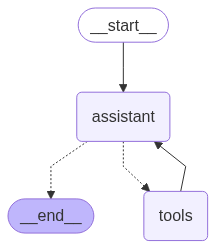

In [26]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

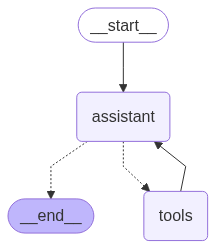

In [27]:
from IPython.display import Image, display
from langgraph.graph.message import add_messages

try:
    display(Image(react_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [29]:


messages = [HumanMessage(content="solve the reclass tax issue ")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    if isinstance(m, AIMessage):
     print(m.content)
            




c:\Repos\FinalYearProject\IndirectTax\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Null values in df:
Feature extraction complete. New features added to df.
Fitting 3 folds for each of 216 candidates, totalling 648 fits


c:\Repos\FinalYearProject\IndirectTax\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validated accuracy: 0.9033
All masked out for region=3, county=6. Fallback to original prediction.
All masked out for region=0, county=15. Fallback to original prediction.

The reclassification of tax issues resulted in resolving the tax concerns for several cities. Specifically:

-  Chula Vista
-  Cary
-  Troy
-  Arlington 
-  Monroeville 
-  Arlington 
-  Boca Raton 
-  Warren 
-  Arlington 
-  Boca Raton 

There were 10 cities where tax reclassification was addressed.
